# Making Graphs for Risk Exposures Compared between Scenarios

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 100)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

### Create interactive sim data 
#### Note: I have saved an old version of this data, you can choose to skip this step and just load the dataset below

Limit this to people of more interest (older) and do a small population for a long time since we aren't looking for population level information 

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              },
                          'input_data':
                              {'input_draw_number': 829
                              }
                          }
                        )
sim.setup()

2023-08-16 09:18:27.213 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-08-16 09:18:27.216 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 829'].
2023-08-16 09:18:27.223 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
#pop0

In [7]:
#sim.list_values()

data1 = pd.concat([pop0,
                   sim.get_value('outreach.exposure')(pop0.index),
                   sim.get_value('lifestyle.exposure')(pop0.index),
                   sim.get_value('polypill.exposure')(pop0.index),
                  ], axis=1)
data1.head()

In [5]:
sim_data = pd.DataFrame()
for step in list(range(0,12)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                      ], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11


In [6]:
sim_data.outreach.unique()

array(['cat2', 'cat1'], dtype=object)

In [6]:
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_baseline_08162023.csv')
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_polypill_08162023.csv')
sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_08162023.csv')
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_outreach_08162023.csv')

## Analyze Data and Set Up for Graphing 

In [7]:
full_data = pd.read_csv('/ihme/homes/lutzes/risk_exposure_baseline_08162023.csv')
full_data_polypill = pd.read_csv('/ihme/homes/lutzes/risk_exposure_polypill_08162023.csv')
full_data_outreach = pd.read_csv('/ihme/homes/lutzes/risk_exposure_outreach_08162023.csv')
full_data_lifestyle = pd.read_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_08162023.csv')

#full_data.head()

/tmp/ipykernel_627396/2456685914.py:1: DtypeWarning: Columns (43,49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('/ihme/homes/lutzes/risk_exposure_baseline_08162023.csv')
/tmp/ipykernel_627396/2456685914.py:2: DtypeWarning: Columns (43,48) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_polypill = pd.read_csv('/ihme/homes/lutzes/risk_exposure_polypill_08162023.csv')
/tmp/ipykernel_627396/2456685914.py:3: DtypeWarning: Columns (42,49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_outreach = pd.read_csv('/ihme/homes/lutzes/risk_exposure_outreach_08162023.csv')
/tmp/ipykernel_627396/2456685914.py:4: DtypeWarning: Columns (42,49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_lifestyle = pd.read_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_08162023.csv')


In [8]:
def data_processing(data):
    test_data = data.loc[(data.age > 25)]
    test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
    test_data = test_data.rename(columns={'Unnamed: 0':'sim_id'})
    test_data = test_data.loc[test_data.step == 11]
    return test_data

In [9]:
test_data = data_processing(full_data)
test_data_polypill = data_processing(full_data_polypill)
test_data_outreach = data_processing(full_data_outreach)
test_data_lifestyle = data_processing(full_data_lifestyle)

## Risk Comparison Graphs

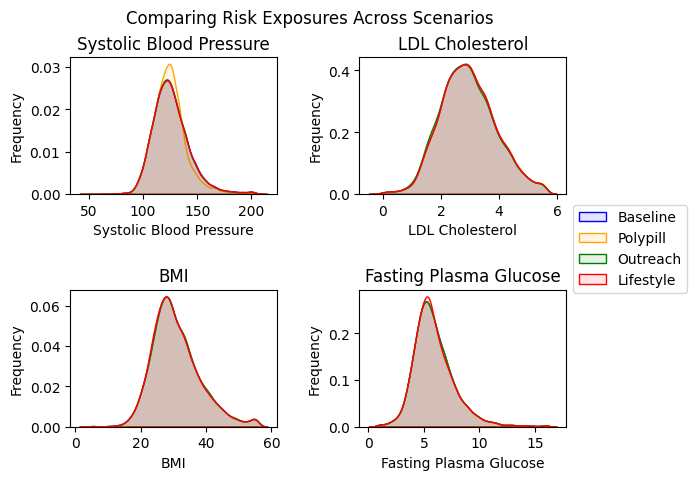

In [10]:
## Add in other interventions 

fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle(f'Comparing Risk Exposures Across Scenarios')
ax = fig.add_subplot(2, 2, 1)

sns.kdeplot(data=test_data, x='high_sbp', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_sbp', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_sbp', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_sbp', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Systolic Blood Pressure')
ax.set_ylabel('Frequency')
ax.set_title('Systolic Blood Pressure')


ax = fig.add_subplot(2, 2, 2)
sns.kdeplot(data=test_data, x='high_ldl', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_ldl', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_ldl', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_ldl', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('LDL Cholesterol')
ax.set_ylabel('Frequency')
ax.set_title('LDL Cholesterol')


ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(data=test_data, x='high_bmi', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_bmi', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_bmi', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_bmi', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')
ax.set_title('BMI')


ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(data=test_data, x='high_fpg', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_fpg', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_fpg', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_fpg', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Fasting Plasma Glucose')
ax.set_ylabel('Frequency')
ax.set_title('Fasting Plasma Glucose')

plt.legend(loc='center left', bbox_to_anchor=(1, 1.3))

plt.show()

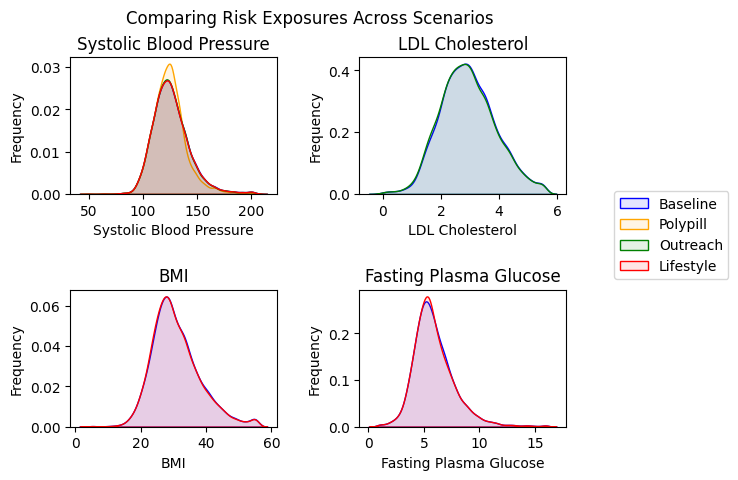

In [16]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle(f'Comparing Risk Exposures Across Scenarios')
ax = fig.add_subplot(2, 2, 1)

sns.kdeplot(data=test_data, x='high_sbp', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_sbp', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_sbp', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_sbp', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Systolic Blood Pressure')
ax.set_ylabel('Frequency')
ax.set_title('Systolic Blood Pressure')
plt.legend(loc='center left', bbox_to_anchor=(2.6, -0.3))


ax = fig.add_subplot(2, 2, 2)
sns.kdeplot(data=test_data, x='high_ldl', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_ldl', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('LDL Cholesterol')
ax.set_ylabel('Frequency')
ax.set_title('LDL Cholesterol')


ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(data=test_data, x='high_bmi', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_bmi', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')
ax.set_title('BMI')


ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(data=test_data, x='high_fpg', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_fpg', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Fasting Plasma Glucose')
ax.set_ylabel('Frequency')
ax.set_title('Fasting Plasma Glucose')

plt.show()